In [2]:
import sys
sys.path.append('../../code')
import torch
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import seaborn as sns
from sbi import inference as sbi_inference
from utils import (linear_scale_array, UniformPrior,
                   get_dataset_psd, get_dataset_peaks, load_posterior, simulator_rc,
                   get_parameter_recovery, get_posterior_predictive_check)
from functools import partial
import dill
from sbi import utils as sbi_utils
import pandas as pd
from sklearn.decomposition import PCA
from matplotlib.patches import Rectangle
from scipy.stats import pearsonr
rng_seed = 123

sns.set()
sns.set_style("white")

device = 'cpu'

sim_type = 'rc_circuit'
data_path = f'../../data/{sim_type}'

with open(f'{data_path}/posteriors/posterior_dicts.pkl', 'rb') as output_file:
    posterior_state_dicts = dill.load(output_file)
with open(f'{data_path}/sbi_sims/prior_dict.pkl', 'rb') as output_file:
    prior_dict = dill.load(output_file)
with open(f'{data_path}/sbi_sims/sim_metadata.pkl', 'rb') as output_file:
    sim_metadata = dill.load(output_file)
with open(f'{data_path}/posteriors/posterior_metadata.pkl', 'rb') as output_file:
    posterior_metadata = dill.load(output_file)
    
dt = sim_metadata['dt'] # Sampling interval used for simulation
tstop = sim_metadata['tstop'] # Sampling interval used for simulation
window_samples = posterior_metadata['window_samples']

# x_orig stores full waveform to be used for embedding
x_orig, theta_orig = np.load(f'{data_path}/sbi_sims/x_sbi.npy'), np.load(f'{data_path}/sbi_sims/theta_sbi.npy')
x_grid, theta_grid = np.load(f'{data_path}/sbi_sims/x_grid.npy'), np.load(f'{data_path}/sbi_sims/theta_grid.npy')

x_orig = x_orig[:, window_samples[0]:window_samples[1]]
x_grid = x_grid[:, window_samples[0]:window_samples[1]]

simulator = partial(simulator_rc, prior_dict=prior_dict, tstop=tstop)

/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/core.py:19: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import format_bytes, parse_bytes, tmpfile
/home/ntolley/anaconda3/envs/sbi/lib/python3.8/site-packages/dask_jobqueue/htcondor.py:6: FutureWarning: parse_bytes is deprecated and will be removed in a future release. Please use dask.utils.parse_bytes instead.
  from distributed.utils import parse_bytes


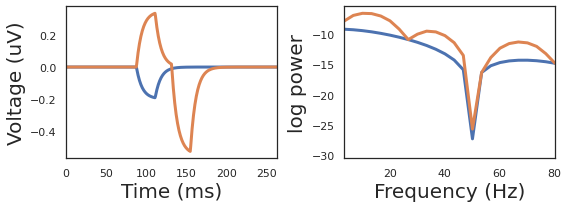

In [3]:
%matplotlib inline
offset_samples = 150
labelsize=20
# Values on [0,1] mapped to range of bounds defined in prior_dict
theta_cond_list = [np.array([0.35, 0.55, 0.5]), np.array([0.35, 0.55, 0.75])]

x_cond_list, theta_dict_list = list(), list()
for theta_cond in theta_cond_list:
    theta_dict = {param_name: param_dict['scale_func'](theta_cond[idx], param_dict['bounds']) for 
                  idx, (param_name, param_dict) in enumerate(prior_dict.items())}

    x_cond = simulator(torch.tensor(theta_cond).float()).T
    x_cond = x_cond[:, window_samples[0]:window_samples[1]]
                   
    theta_dict_list.append(theta_dict)
    x_cond_list.append(x_cond)

# Plot conditioning features    
t_vec = np.linspace(0, tstop, x_cond_list[0].squeeze().shape[0])

plot_t_vec = t_vec - t_vec[offset_samples]
time_lim = [0, plot_t_vec[-1]]

x_cond_psd0, f = get_dataset_psd(x_cond_list[0], posterior_metadata['fs'])
x_cond_psd1, _ = get_dataset_psd(x_cond_list[1], posterior_metadata['fs'])

#x_cond_peak0 = get_dataset_peaks(x_cond_list[0], tstop)
#x_cond_peak1 = get_dataset_peaks(x_cond_list[1], tstop)

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(plot_t_vec, x_cond_list[0].squeeze(), linewidth=3)
plt.plot(plot_t_vec, x_cond_list[1].squeeze(), linewidth=3)
plt.xlabel('Time (ms)', fontsize=labelsize)
plt.xlim(time_lim)
plt.ylabel('Voltage (uV)', fontsize=labelsize)

plt.subplot(1,2,2)
plt.plot(f, x_cond_psd0.squeeze(), linewidth=3)
plt.plot(f, x_cond_psd1.squeeze(), linewidth=3)
plt.xlabel('Frequency (Hz)', fontsize=labelsize)
plt.xlim([f[0], 80])
plt.ylabel('log power', fontsize=labelsize)

plt.tight_layout()

plt.savefig('rc_circuit_posterior_compare_cond.svg')

In [4]:
x_noise_amp = posterior_metadata['x_noise_amp']
x_noise = np.random.random(x_orig.shape) * x_noise_amp - (x_noise_amp / 2)
x_orig_noise = x_orig + x_noise

pca4 = PCA(n_components=4, random_state=rng_seed)
pca4.fit(x_orig_noise)

pca30 = PCA(n_components=30, random_state=rng_seed)
pca30.fit(x_orig_noise)

PCA(n_components=30, random_state=123)

In [5]:
prior = UniformPrior(parameters=list(prior_dict.keys()))
n_params = len(prior_dict)
limits = list(prior_dict.values())

nval_samples = 10


# Collect plotting data outside loop
scatter_data_list = list()
dist_data_list = list()
ppc_data_list = list()
theta_data_list = list()

input_type_list = ['pca30', 'pca4', 'peak', 'bandpower']
for plot_idx, input_type in enumerate(input_type_list):
    posterior_dict = posterior_state_dicts[input_type]
    state_dict = posterior_dict['posterior']
    n_params = posterior_dict['n_params']
    n_sims = posterior_dict['n_sims']
    input_dict = posterior_dict['input_dict']

    embedding_net =  input_dict['embedding_func'](**input_dict['embedding_dict'])
    
    # Samples from posterior conditoned on grid sweep sims
    x_val = np.load(f'{data_path}/sbi_sims/x_{input_type}_validation.npy')
    x_val = x_val[:, window_samples[0]:window_samples[1]]

    theta_val = np.load(f'{data_path}/sbi_sims/theta_{input_type}_validation.npy')


    print(f'Conditioning Feature: {input_type}')

    # Posterior scatter plot: get samples for conditoning waveform
    num_samples = 1000
    all_labels = list(prior_dict.keys())
    all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]

    df_list, theta_cond_transformed_list = list(), list()
    cond_name = ['Large', 'Small']
    for x_cond, cond_name, theta_cond in zip(x_cond_list, cond_name, theta_cond_list):
        load_info = {name: {'x_train': posterior_dict['input_dict']['feature_func'](x_orig), 
                            'x_cond': posterior_dict['input_dict']['feature_func'](x_cond)}
                     for name, posterior_dict in posterior_state_dicts.items()}
        posterior = load_posterior(state_dict=state_dict,
                                   x_infer=torch.tensor(load_info[input_type]['x_train'][:10,:]).float(),
                                   theta_infer=torch.tensor(theta_orig[:10,:]), prior=prior, embedding_net=embedding_net)

        samples = posterior.sample((num_samples,), x=torch.tensor(load_info[input_type]['x_cond'].squeeze()))
        samples_transformed = linear_scale_array(samples.numpy(), all_bounds)

        theta_cond_transformed = linear_scale_array(theta_cond.reshape(1,-1), all_bounds)[0]
        df_dict = {name: samples_transformed[:, idx] for idx, name in enumerate(all_labels)}
        df_dict['cond_name'] = np.repeat(cond_name, num_samples)

        df_temp = pd.DataFrame(df_dict)

        theta_cond_transformed_list.append(theta_cond_transformed)
        df_list.append(df_temp)
    df = pd.concat(df_list)
    
    scatter_data_list.append(df)
        
    # Parameter recovery
    dist_array = get_parameter_recovery(theta_val, theta_grid, n_samples=nval_samples)
    dist_data_list.append(dist_array)


    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    ppc_array = get_posterior_predictive_check(x_val, x_grid, n_samples=nval_samples)
    ppc_data_list.append(ppc_array)
    
    theta_data_list.append(theta_cond_transformed_list)




Conditioning Feature: pca30


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: pca4


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: peak


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Conditioning Feature: bandpower


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

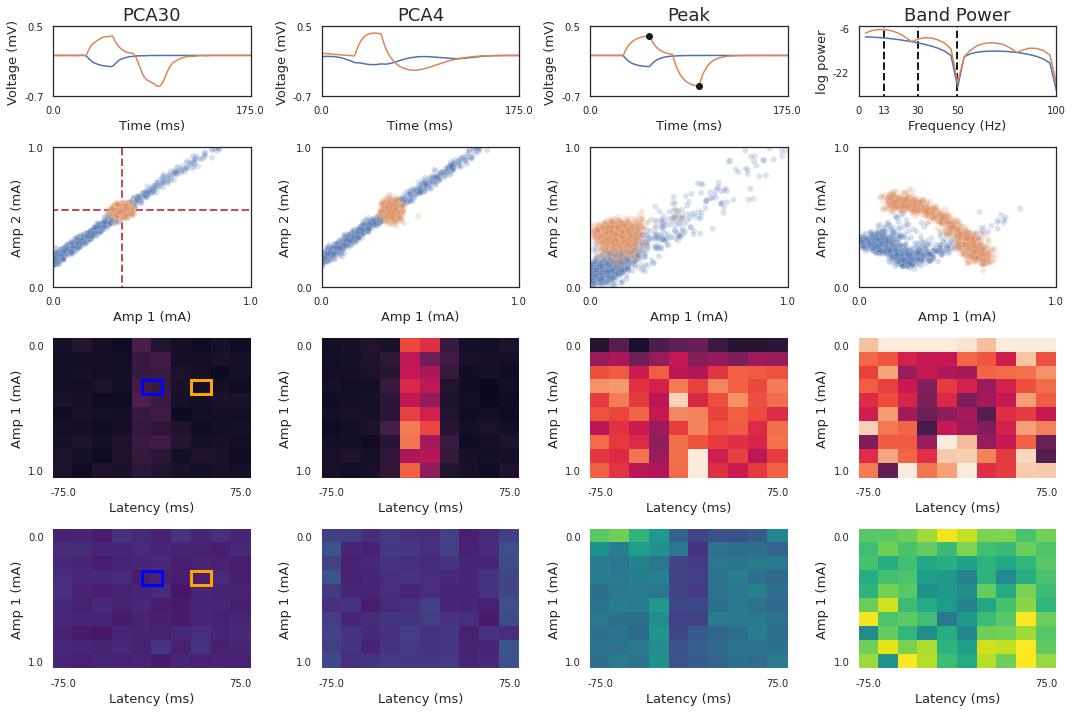

In [6]:
param_labels = ['Amp 1 (mA)', 'Amp 2 (mA)', 'Latency (ms)']
title_list = ['PCA30', 'PCA4', 'Peak', 'Band Power']

nval_samples = 10

titlesize = 18
ticksize = 10
labelsize = 13

tick_dict = dict()
for p_idx, param_dict in enumerate(prior_dict.values()):
    bounds = param_dict['bounds']
    ticks = np.round(np.linspace(bounds[0], bounds[1], nval_samples), decimals=2)
    tick_dict[f'p{p_idx}_tick_pos'] = ticks
    
    ticks = ticks.astype(str)
    ticks[1:-1] = np.repeat('', nval_samples-2)
    tick_dict[f'p{p_idx}_tick_labels'] = ticks


fig, axes = plt.subplots(4,4, figsize=(15,10), gridspec_kw={'height_ratios': [0.5, 1, 1, 1]})

waveform_ylim = [-0.7, 0.5]
waveform_ylabels = np.array(waveform_ylim)
power_ylim = [-22, -6]
time_lim = np.round([t_vec[250], t_vec[-50]], decimals=0)
time_labels = time_lim - time_lim[0]

freq_ticks = [0, 13, 30, 50, 100]
freq_lim = [0, 100]

# Plot PCA30 transformed waveform
axes[0,0].plot(t_vec, pca30.inverse_transform(pca30.transform(x_cond_list[0])).squeeze())
axes[0,0].plot(t_vec, pca30.inverse_transform(pca30.transform(x_cond_list[1])).squeeze())
axes[0,0].set_xlabel('Time (ms)', fontsize=labelsize)
axes[0,0].set_ylabel('Voltage (mV)', fontsize=labelsize)
axes[0,0].set_xticks(time_lim)
axes[0,0].set_xticklabels(time_labels, fontsize=ticksize)
axes[0,0].set_xlim(time_lim)
axes[0,0].set_ylim(waveform_ylim)
axes[0,0].set_yticks(waveform_ylim)
axes[0,0].set_yticklabels(waveform_ylabels, fontsize=ticksize)

# Plot PCA4 transformed waveform
axes[0,1].plot(t_vec, pca4.inverse_transform(pca4.transform(x_cond_list[0])).squeeze())
axes[0,1].plot(t_vec, pca4.inverse_transform(pca4.transform(x_cond_list[1])).squeeze())
axes[0,1].set_xlabel('Time (ms)', fontsize=labelsize)
axes[0,1].set_ylabel('Voltage (mV)', fontsize=labelsize)
axes[0,1].set_xticks(time_lim)
axes[0,1].set_xticklabels(time_labels, fontsize=ticksize)
axes[0,1].set_xlim(time_lim)
axes[0,1].set_ylim(waveform_ylim)
axes[0,1].set_yticks(waveform_ylim)
axes[0,1].set_yticklabels(waveform_ylabels, fontsize=ticksize)

# Plot peaks
axes[0, 2].scatter(t_vec[np.argmax(x_cond_list[1])], np.max(x_cond_list[1]), color='k', zorder=10)
axes[0, 2].scatter(t_vec[np.argmin(x_cond_list[1])], np.min(x_cond_list[1]), color='k', zorder=10)

axes[0,2].plot(t_vec, x_cond_list[0].squeeze())
axes[0,2].plot(t_vec, x_cond_list[1].squeeze())

axes[0,2].set_xlabel('Time (ms)', fontsize=labelsize)
axes[0,2].set_ylabel('Voltage (mV)', fontsize=labelsize)
axes[0,2].set_xticks(time_lim)
axes[0,2].set_xticklabels(time_labels, fontsize=ticksize)
axes[0,2].set_yticks(waveform_ylim)
axes[0,2].set_yticklabels(waveform_ylim, fontsize=ticksize)
axes[0,2].set_xlim(time_lim)

# Plot PSD
axes[0,3].plot(f, x_cond_psd0.squeeze())
axes[0,3].plot(f, x_cond_psd1.squeeze())

axes[0,3].set_xlabel('Frequency (Hz)', fontsize=labelsize)
axes[0,3].set_ylabel('log power', fontsize=labelsize)
axes[0,3].set_xticks(freq_ticks)
axes[0,3].set_xticklabels(freq_ticks, fontsize=ticksize)
axes[0,3].set_yticks(power_ylim)
axes[0,3].set_yticklabels(power_ylim, fontsize=ticksize)
axes[0,3].set_ylim(axes[0,3].get_ylim())
axes[0,3].vlines([13, 30, 50], ymin=-1e3, ymax=1e3, color='k', linestyle='--', linewidth=2, alpha=1.0)
axes[0,3].set_xlim(freq_lim)

for plot_idx, input_type in enumerate(input_type_list):
    axes[0, plot_idx].set_title(title_list[plot_idx], fontsize=titlesize)

    df = scatter_data_list[plot_idx]
    dist_array = dist_data_list[plot_idx]
    ppc_array = ppc_data_list[plot_idx]
    
    # Posterior scatter plot
    sns.scatterplot(data=scatter_data_list[plot_idx], x='amp1', y='amp2', hue='cond_name', legend=False, alpha=0.2,
                    ax=axes[1, plot_idx])
    axes[1, plot_idx].set_ylim(prior_dict['amp2']['bounds'])
    axes[1, plot_idx].set_xlim(prior_dict['amp1']['bounds'])
    axes[1, plot_idx].set_xticks(tick_dict['p0_tick_pos'])
    axes[1, plot_idx].set_xticklabels(tick_dict['p0_tick_labels'], fontsize=ticksize)
    axes[1, plot_idx].set_yticks(tick_dict['p1_tick_pos'])
    axes[1, plot_idx].set_yticklabels(tick_dict['p1_tick_labels'], rotation=0, fontsize=ticksize)
    
    axes[1, plot_idx].set_xlabel('Amp 1 (mA)', fontsize=labelsize)
    axes[1, plot_idx].set_ylabel('Amp 2 (mA)', fontsize=labelsize)
    
    # Parameter recovery
    sns.heatmap(dist_array[:,0].reshape(nval_samples, nval_samples, nval_samples)[:,5,:], ax=axes[2,plot_idx],
                vmin=0, vmax=0.3, xticklabels=tick_dict['p2_tick_labels'], yticklabels=tick_dict['p0_tick_labels'], cbar=False)
    axes[2, plot_idx].set_xlabel(param_labels[2], fontsize=labelsize)
    axes[2, plot_idx].set_ylabel(param_labels[0], fontsize=labelsize)
    axes[2, plot_idx].set_yticklabels(axes[2, plot_idx].get_yticklabels(), fontsize=ticksize, rotation=0)
    axes[2, plot_idx].set_xticklabels(axes[2, plot_idx].get_xticklabels(), fontsize=ticksize, rotation=0)

    # Posterior Predictive Check: RMSE between ground truth sim and posterior samples
    sns.heatmap(ppc_array.reshape(nval_samples, nval_samples, nval_samples)[:,5,:], ax=axes[3,plot_idx],
                vmin=0, vmax=0.2, xticklabels=tick_dict['p2_tick_labels'], yticklabels=tick_dict['p0_tick_labels'], cmap='viridis', cbar=False)
    axes[3, plot_idx].set_xlabel(param_labels[2], fontsize=labelsize)
    axes[3, plot_idx].set_ylabel(param_labels[0], fontsize=labelsize)
    axes[3, plot_idx].set_yticklabels(axes[3, plot_idx].get_yticklabels(), fontsize=ticksize, rotation=0)
    axes[3, plot_idx].set_xticklabels(axes[3, plot_idx].get_xticklabels(), fontsize=ticksize, rotation=0)
    
# Plot groundtruth (same for both observations on first 2 dimensions)
axes[1,0].vlines([theta_data_list[0][0][0]], ymin=-1e3, ymax=1e3, color='r', linestyle='--', linewidth=2, alpha=1.0, zorder=-10)
axes[1,0].hlines([theta_data_list[0][0][1]], xmin=-1e3, xmax=1e3, color='r', linestyle='--', linewidth=2, alpha=1.0, zorder=-10)

# Patch coordinates define bottom left corner, need 
axes[2,0].add_patch(Rectangle((4.5,3), 1, 1, fill=False, edgecolor='blue', lw=3))
axes[2,0].add_patch(Rectangle((7.0,3), 1, 1, fill=False, edgecolor='orange', lw=3))
axes[3,0].add_patch(Rectangle((4.5,3), 1, 1, fill=False, edgecolor='blue', lw=3))
axes[3,0].add_patch(Rectangle((7.0,3), 1, 1, fill=False, edgecolor='orange', lw=3))

plt.tight_layout()
plt.savefig('rc_circuit_summary_feature_compare.svg')

pca30


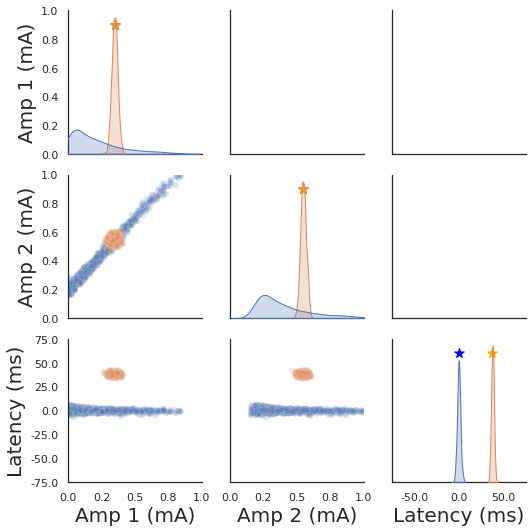

In [7]:
feature_idx = 0
print(input_type_list[feature_idx])

labelsize=20

df = scatter_data_list[feature_idx]
theta_cond_transformed_list = theta_data_list[feature_idx]

all_bounds = [param_dict['bounds'] for param_dict in prior_dict.values()]
g = sns.PairGrid(df, hue='cond_name', diag_sharey=False, corner=False)
g.map_lower(sns.scatterplot, alpha=0.2)
#g.map_upper(sns.kdeplot, fill=False)
g.map_diag(sns.kdeplot, fill=True)

for idx in range(3):    
    # Add space to visuzalize groundtruth tick marks at top
    y_diff = np.abs(all_bounds[idx][1] - all_bounds[idx][0])

    g.axes[idx, idx].set_xlim(all_bounds[idx])
    g.axes[idx, idx].set_ylim(all_bounds[idx])
    
    g.axes[idx,idx].scatter(theta_cond_transformed_list[0][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='blue', marker='*', s=100)
    g.axes[idx,idx].scatter(theta_cond_transformed_list[1][idx], all_bounds[idx][1] - y_diff*0.1,
                            color='orange', marker='*', s=100)
    
    g.axes[idx,0].set_ylabel(param_labels[idx], fontsize=labelsize)
    g.axes[2,idx].set_xlabel(param_labels[idx], fontsize=labelsize)

for idx1 in range(3):
    for idx2 in range(3):
        if g.axes[idx1, idx2] != None:
            g.axes[idx1, idx2].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
            g.axes[idx1, idx2].xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
plt.tight_layout()
plt.savefig('rc_circuit_posterior_compare.svg')

In [ ]:
for feature_idx, input_type in enumerate(input_type_list):
    print(input_type)
    df_feature = samples_data_list[feature_idx]
    df_large = df_feature[df_feature['cond_name'] == 'Large']
    df_small = df_feature[df_feature['cond_name'] == 'Small']
    print(input_type_list[feature_idx])

    theta_large = torch.tensor(df_large[['amp1', 'amp2', 'latency']].values)
    theta_small = torch.tensor(df_small[['amp1', 'amp2', 'latency']].values)

    x_large = simulator(theta_large)
    x_large = x_large[:, window_samples[0]:window_samples[1]]
    x_small = simulator(theta_small)
    x_small = x_small[:, window_samples[0]:window_samples[1]]

    #dist_large_array = get_parameter_recovery(theta_large, theta_cond_list[0].reshape(1,-1), n_samples=theta_large.shape[0])
    #dist_small_array = get_parameter_recovery(theta_small, theta_cond_list[1].reshape(1,-1), n_samples=theta_small.shape[0])

    ppc_large_array = get_posterior_predictive_check(x_large.numpy(), x_cond_list[0].reshape(1,-1), n_samples=x_large.shape[0])
    ppc_small_array = get_posterior_predictive_check(x_small, x_cond_list[1].reshape(1,-1), n_samples=x_small.shape[0])

    print(f'Large amp1/amp2 PRE:{dist_large_array}; PPC:{ppc_large_array}')
    print(f'Small amp2/amp1 PRE:{dist_small_array}; PPC:{ppc_small_array}')

## Calculate correlation and average heatmap values

In [8]:
for feature_idx, input_type in enumerate(input_type_list):
    dist_array = dist_data_list[feature_idx]
    ppc_array = ppc_data_list[feature_idx]
    
    print(f'{input_type} corrcoef')
    #print(scatter_data_list[feature_idx].corr())
    
    df_feature = scatter_data_list[feature_idx]
    df_large = df_feature[df_feature['cond_name'] == 'Large']
    theta_large = df_large[['prox_weight', 'dist_weight', 'latency']].values
    
    df_small = df_feature[df_feature['cond_name'] == 'Small']
    theta_small = df_small[['prox_weight', 'dist_weight', 'latency']].values
    
    corr_large, p_large = pearsonr(df_large['amp1'], df_large['amp2'])
    corr_small, p_small = pearsonr(df_small['amp1'], df_small['amp2'])
    print(f'Large Amp1/Amp2 corr:{corr_large};  p:{p_large}')
    print(f'Small Amp1/Amp2 corr:{corr_small};  p:{p_small}')
    
    print(f'PRE Avg: {np.mean(dist_array): .3f} ± {np.std(dist_array): .2f}')
    print(f'PPC Avg: {np.mean(ppc_array): .3f} ± {np.std(ppc_array): .3f}')
    print(f'')
    print('')

pca30 corrcoef
Large Amp1/Amp2 corr:0.9934736306024716;  p:0.0
Small Amp1/Amp2 corr:0.0352229402293394;  p:0.2657946087338701
PRE Avg:  0.024 ±  0.03
PPC Avg:  0.021 ±  0.008


pca4 corrcoef
Large Amp1/Amp2 corr:0.9939838595733655;  p:0.0
Small Amp1/Amp2 corr:-0.12656641976197078;  p:5.9818388501189006e-05
PRE Avg:  0.048 ±  0.05
PPC Avg:  0.029 ±  0.011


peak corrcoef
Large Amp1/Amp2 corr:0.9249769216110699;  p:0.0
Small Amp1/Amp2 corr:0.09964326269478233;  p:0.001605475230988593
PRE Avg:  0.152 ±  0.10
PPC Avg:  0.072 ±  0.027


bandpower corrcoef
Large Amp1/Amp2 corr:-0.08630296573348552;  p:0.006317649453268956
Small Amp1/Amp2 corr:-0.9391240770201602;  p:0.0
PRE Avg:  0.241 ±  0.13
PPC Avg:  0.146 ±  0.055




## Save SVG to use colorbars for main figures

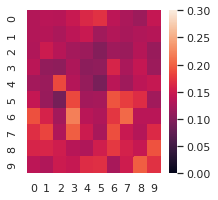

In [20]:
plt.figure(figsize=(3,3))
sns.heatmap(ppc_array.reshape(nval_samples, nval_samples, nval_samples)[:,5,:], cbar=True,
            vmin=0.0, vmax=0.3)
plt.savefig('rc_circuit_wasserstein_color_bar.svg')

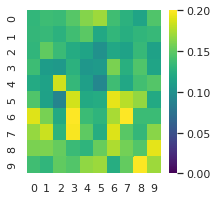

In [21]:
plt.figure(figsize=(3,3))
sns.heatmap(ppc_array.reshape(nval_samples, nval_samples, nval_samples)[:,5,:], cmap='viridis', cbar=True,
            vmin=0.0, vmax=0.2)
plt.savefig('rc_circuit_ppc_color_bar.svg')